# Import All Required libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier, plot_importance


# Read Data

In [2]:
warnings.filterwarnings("ignore")# Ignore all warnings

df=pd.read_csv('Crash_Reporting_-_Drivers_Data.csv')
df.head()

,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Name,Off-Road Description,Municipality,...,Vehicle Going Dir,Speed Limit,Driverless Vehicle,Parked Vehicle,Vehicle Year,Vehicle Make,Vehicle Model,Latitude,Longitude,Location
0,DM8479000T,210020119,Takoma Park Police Depart,Property Damage Crash,05/27/2021 07:40:00 PM,NaN,NaN,NaN,IN PARKING LOT,NaN,...,NaN,0,No,Yes,2017,HINO,TWK,38.987657,-76.987545,"(38.98765667, -76.987545)"
1,MCP2970000R,15045937,MONTGOMERY,Property Damage Crash,09/11/2015 01:29:00 PM,NaN,NaN,NaN,Parking Lot: \n2525 Ennalls Ave,NaN,...,South,5,No,No,2012,TOYOTA,SU,39.039917,-77.053649,"(39.03991652, -77.05364898)"
2,MCP20160036,180040948,Montgomery County Police,Property Damage Crash,08/17/2018 02:25:00 PM,NaN,NaN,NaN,PARKING LOT OF 16246 FREDERICK RD,NaN,...,West,15,No,No,2015,MAZD,TK,38.743373,-77.546997,"(38.743373, -77.54699707)"
3,EJ7879003C,230048975,Gaithersburg Police Depar,Injury Crash,08/11/2023 06:00:00 PM,NaN,NaN,NaN,1 N SUMMIT DRIVE,NaN,...,Unknown,15,No,No,2018,RAM,TK,39.145873,-77.191940,"(39.14587303, -77.19194047)"
4,MCP2967004Y,230070277,Montgomery County Police,Property Damage Crash,12/06/2023 06:42:00 PM,Maryland (State),CONNECTICUT AVE,BALTIMORE ST,NaN,KENSINGTON,...,South,35,No,No,2017,AUDI,A3,39.025170,-77.076333,"(39.02517017, -77.07633333)"


# Explore data

In [3]:
df.shape

(184521, 39)

# Data Preprocessing

<h3>Data Cleaning</h3>

<h4 style="color: blue;"> Handle missing values</h4>

In [4]:
df.isnull().sum()

Report Number                         0
Local Case Number                     0
Agency Name                           0
ACRS Report Type                      0
Crash Date/Time                       0
Route Type                        18112
Road Name                         18629
Cross-Street Name                 23630
Off-Road Description             167447
Municipality                     165395
Related Non-Motorist             178633
Collision Type                      585
Weather                           13356
Surface Condition                 21309
Light                              1445
Traffic Control                   26565
Driver Substance Abuse            31321
Non-Motorist Substance Abuse     179779
Person ID                             0
Driver At Fault                       0
Injury Severity                     761
Circumstance                     149761
Driver Distracted By                835
Drivers License State             11387
Vehicle ID                            0


In [5]:
# Fill missing values in numeric columns with the mean
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Fill missing values in categorical columns with the mode
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
df.isnull().sum().sum()

0

<h4 style="color: blue;"> Handle duplicates</h4>

In [6]:
df.duplicated().any()

False

<h4 style="color: blue;">Data filtering </h4>

In [7]:
# Drop specified columns from the DataFrame
df2 = df[~df['Weather'].isin(['Rain', 'Cloudy', 'Clear'])]
# Drop rows where the Collision Type column has 'OTHER' or 'UNKNOWN'
df2 = df2[~df2['Collision Type'].isin(['OTHER', 'UNKNOWN'])]



<h3>Exploratory Data Analysis</h3>

<h4 style="color: blue;">What are the most common weather conditions reported during crashes, and how do they vary across different collision types?</h4>

In [8]:
# Define the list of weather conditions to analyze
weather_conditions = [
    'CLEAR', 'CLOUDY', 'RAINING', 'SNOW', 'FOGGY', 'OTHER', 'UNKNOWN', 'WINTRY MIX',
    'SEVERE WINDS', 'SLEET', 'BLOWING SNOW', 'BLOWING SAND, SOIL, DIRT','Fog, Smog, Smoke', 'Unknown', 
    'Severe Crosswinds',
    'Snow', 'Freezing Rain Or Freezing Drizzle', 'Blowing Snow', 'Sleet Or Hail'
]

# Filter the DataFrame for the specified weather conditions
filtered_df = df2[df2['Weather'].isin(weather_conditions)]

# Group by 'Weather' and 'Collision Type', then count occurrences
weather_collision_counts = filtered_df.groupby(['Weather', 'Collision Type']).size().reset_index(name='Count')

# Delete rows where Count is less than 100
filtered_weather_collision_counts = weather_collision_counts[weather_collision_counts['Count'] >= 150]


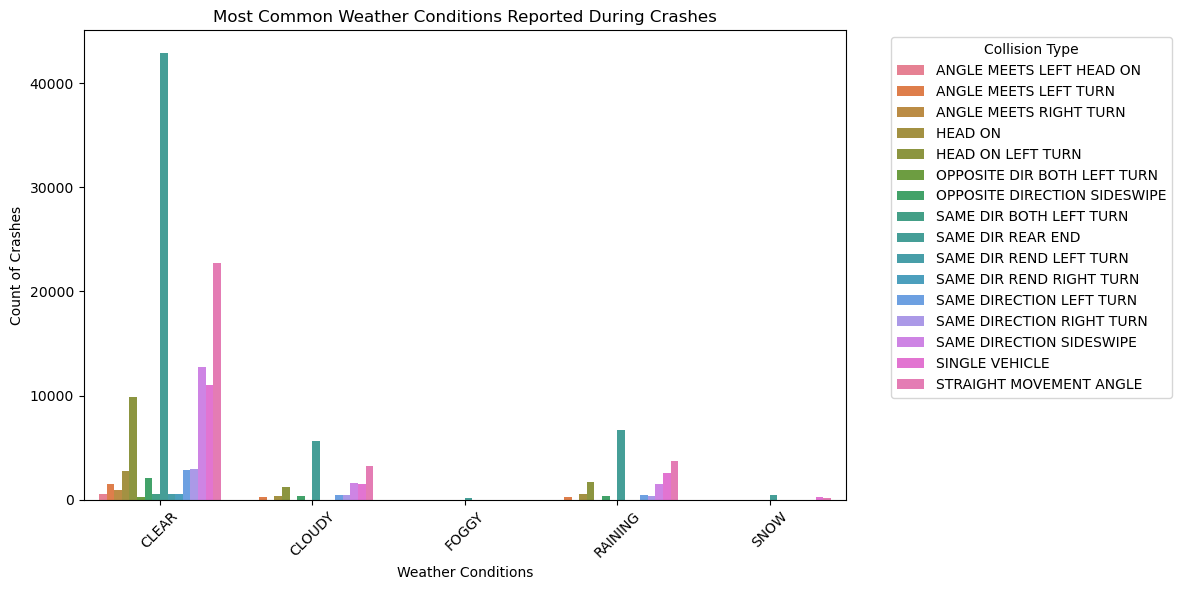

In [9]:
# Set color palette for collision types
palette = sns.color_palette("husl", len(filtered_weather_collision_counts['Collision Type'].unique()))

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=filtered_weather_collision_counts, 
            x='Weather', 
            y='Count', 
            hue='Collision Type', 
            palette=palette,
            dodge=True)

# Add titles and labels
plt.title('Most Common Weather Conditions Reported During Crashes')
plt.xlabel('Weather Conditions')
plt.ylabel('Count of Crashes')
plt.xticks(rotation=45)

# Customize legend
plt.legend(title='Collision Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot with tight layout
plt.tight_layout()
plt.show()

In [10]:
# Create the table using pivot_table
collision_table = filtered_weather_collision_counts.pivot_table(
    index='Weather', 
    columns='Collision Type', 
    values='Count', 
    aggfunc='sum',
    fill_value=0  # Replace missing values with 0
)

# # Reset index for better readability
# collision_table = collision_table.reset_index()

# # Display the table
# print(collision_table)
filtered_weather_collision_counts

,Weather,Collision Type,Count
21,CLEAR,ANGLE MEETS LEFT HEAD ON,507
22,CLEAR,ANGLE MEETS LEFT TURN,1498
23,CLEAR,ANGLE MEETS RIGHT TURN,951
24,CLEAR,HEAD ON,2766
25,CLEAR,HEAD ON LEFT TURN,9824
26,CLEAR,OPPOSITE DIR BOTH LEFT TURN,237
27,CLEAR,OPPOSITE DIRECTION SIDESWIPE,2104
28,CLEAR,SAME DIR BOTH LEFT TURN,578
29,CLEAR,SAME DIR REAR END,42932
30,CLEAR,SAME DIR REND LEFT TURN,539


<h4 style="color: blue;">How does driver distraction correlate with the extent of vehicle damage reported in crashes?</h4>

In [11]:
# Drop 'OTHER' and 'UNKNOWN' from Vehicle Damage Extent column
df2 = df[~df['Vehicle Damage Extent'].isin(['OTHER', 'UNKNOWN','DISABLING', 'Superficial'])]

# Drop 'UNKNOWN', 'OTHER DISTRACTION', and 'Unknown' from Driver Distracted By column
df2 = df2[~df['Driver Distracted By'].isin(['UNKNOWN', 'OTHER DISTRACTION', 'Unknown', 'Not Distracted'])]


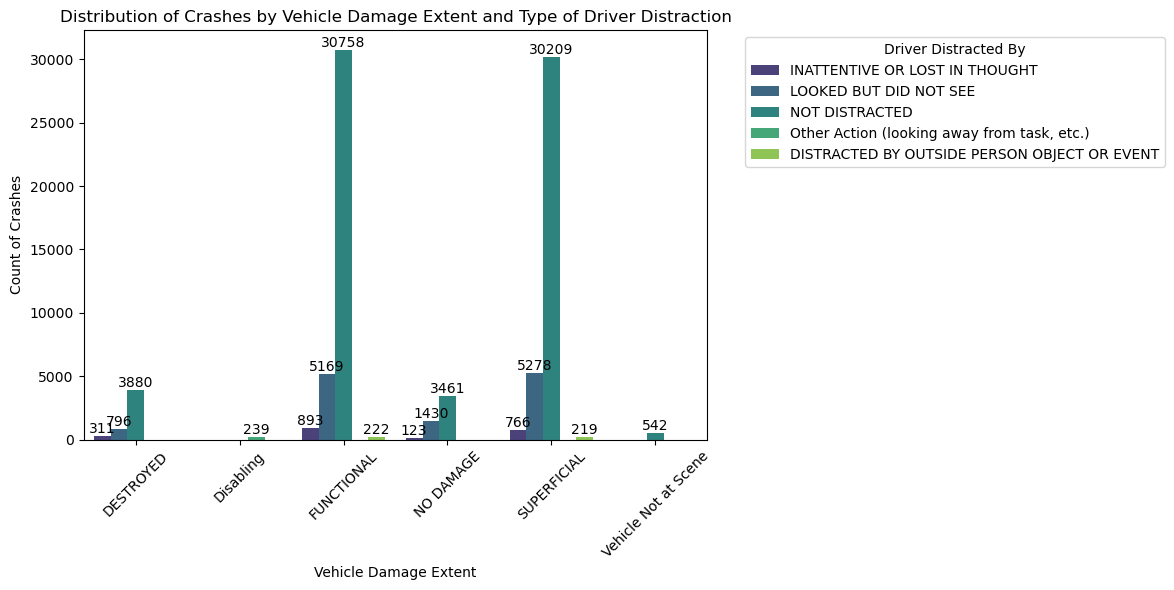

In [12]:
# Group by 'Vehicle Damage Extent' and 'Driver Distracted By', then count occurrences
damage_distraction_counts = df2.groupby(['Vehicle Damage Extent', 'Driver Distracted By']).size().reset_index(name='Count')
# Drop rows where the 'Count' is less than 100
filtered_damage_distraction_counts = damage_distraction_counts[damage_distraction_counts['Count'] >= 100]

# Set the color palette
palette = sns.color_palette("viridis", len(filtered_damage_distraction_counts['Driver Distracted By'].unique()))

# Create a bar plot
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(
    data=filtered_damage_distraction_counts,
    x='Vehicle Damage Extent',
    y='Count',
    hue='Driver Distracted By',
    palette=palette,
    dodge=True
)

# Add values on the bars
for p in bar_plot.patches:
    bar_plot.annotate(
        format(p.get_height(), '.0f'),  # Format as integer
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Position of the text
        ha='center', va='center',
        xytext=(0, 5),  # Offset text position slightly above the bar
        textcoords='offset points'
    )

# Add titles and labels
plt.title('Distribution of Crashes by Vehicle Damage Extent and Type of Driver Distraction')
plt.xlabel('Vehicle Damage Extent')
plt.ylabel('Count of Crashes')
plt.xticks(rotation=45)

# Customize legend
plt.legend(title='Driver Distracted By', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot with tight layout
plt.tight_layout()
plt.show()


In [13]:
# Create a pivot table
damage_distraction_table = filtered_damage_distraction_counts.pivot_table(
    index='Vehicle Damage Extent',            # Rows will be unique Vehicle Damage Extent
    columns='Driver Distracted By',           # Columns will be unique Driver Distracted By
    values='Count',                            # Values to fill the table
    fill_value=0                               # Fill missing values with 0
)

# # Reset index to make it a DataFrame
# damage_distraction_table.reset_index(inplace=True)

# # Display the table
# print(damage_distraction_table)
filtered_damage_distraction_counts


,Vehicle Damage Extent,Driver Distracted By,Count
6,DESTROYED,INATTENTIVE OR LOST IN THOUGHT,311
7,DESTROYED,LOOKED BUT DID NOT SEE,796
9,DESTROYED,NOT DISTRACTED,3880
18,Disabling,"Other Action (looking away from task, etc.)",239
24,FUNCTIONAL,DISTRACTED BY OUTSIDE PERSON OBJECT OR EVENT,222
26,FUNCTIONAL,INATTENTIVE OR LOST IN THOUGHT,893
27,FUNCTIONAL,LOOKED BUT DID NOT SEE,5169
29,FUNCTIONAL,NOT DISTRACTED,30758
46,NO DAMAGE,INATTENTIVE OR LOST IN THOUGHT,123
47,NO DAMAGE,LOOKED BUT DID NOT SEE,1430


In [14]:
df = df[df['Driver At Fault'] != 'Unknown']

# Data encoding

In [15]:
# Select relevant features for the model
features = ['Surface Condition', 'Driver Substance Abuse','Weather', 'Driver Distracted By'] 
target = 'Driver At Fault'  # Target variable

# Encoding categorical variables
df_encoded = df.copy()
label_encoders = {}

for column in features + [target]:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column].astype(str))
    label_encoders[column] = le

# Split the data into training and testing sets
X = df_encoded[features]
y = df_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Build a Predictive Model to Classify Whether a Driver is at Fault

In [16]:
# Initialize and train the Gradient Boosting Classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Confusion Matrix:
[[23396  1705]
 [ 9426 19424]]


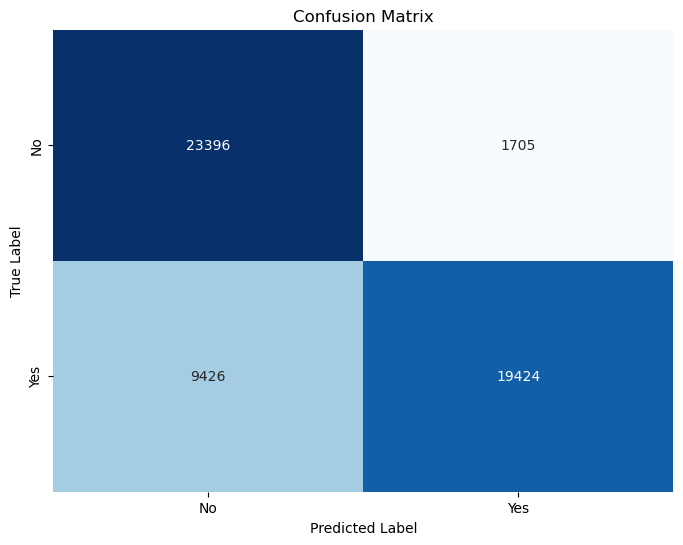

              precision    recall  f1-score   support

           0       0.71      0.93      0.81     25101
           1       0.92      0.67      0.78     28850

    accuracy                           0.79     53951
   macro avg       0.82      0.80      0.79     53951
weighted avg       0.82      0.79      0.79     53951



In [17]:
# Predictions
y_pred = model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoders[target].classes_,
            yticklabels=label_encoders[target].classes_)

# Add titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print the classification report
print(classification_report(y_test, y_pred))

In [18]:
# Function to predict if the driver is at fault based on new input
def predict_driver_fault(surface_condition, driver_substance_abuse, weather, distraction):
    # Encode input features using the fitted LabelEncoders
    input_data = {
        'Surface Condition': surface_condition,
        'Driver Substance Abuse':driver_substance_abuse,
        'Weather': weather,
        'Driver Distracted By': distraction
    }
    encoded_input = {feature: label_encoders[feature].transform([input_data[feature]])[0] for feature in features}
    
    # Convert to DataFrame for model input
    input_df = pd.DataFrame([encoded_input])
    
    # Predict using the trained model
    prediction = model.predict(input_df)[0]
    
    # Decode the prediction
    prediction_label = label_encoders[target].inverse_transform([prediction])[0]
    
    return prediction_label

# Input to predict driver at fault or not
surface_condition = 'WET'
driver_substance_abuse='NONE DETECTED'
weather = 'RAINING'         
distraction = 'NOT DISTRACTED'  
# Output the prediction
predicted_fault = predict_driver_fault(surface_condition, driver_substance_abuse, weather, distraction)
print(f"Prediction: The driver is {'at fault' if predicted_fault == 1 else 'not at fault'}")

Prediction: The driver is not at fault


# Using a Gradient-Boosting Algorithm to Identify Significant Predictors of Crash Injury Severity

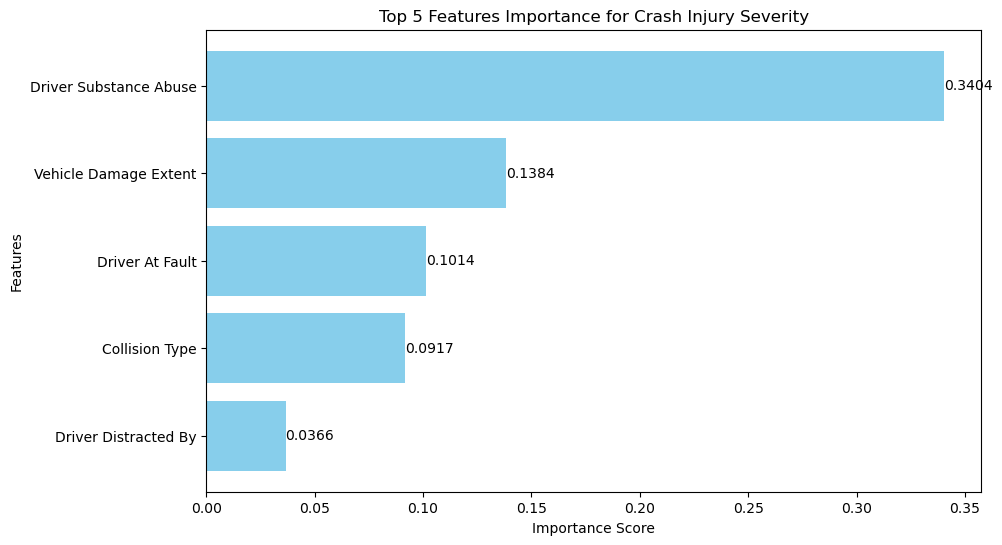

In [19]:
# Drop specified columns
columns_to_drop = ['ACRS Report Type', 'Local Case Number', 'Light']
df = df.drop(columns=columns_to_drop)

# Define target variable for injury severity
injury_target = 'Injury Severity'  # Adjust based on your column names

# Use all columns except the target variable for features
injury_features = df.columns[df.columns != injury_target].tolist()

# Encode categorical variables
df_injury_encoded = df.copy()

for column in injury_features + [injury_target]:
    le = LabelEncoder()
    df_injury_encoded[column] = le.fit_transform(df_injury_encoded[column].astype(str))

# Split the data into training and testing sets
X_injury = df_injury_encoded[injury_features]
y_injury = df_injury_encoded[injury_target]

X_train_injury, X_test_injury, y_train_injury, y_test_injury = train_test_split(X_injury, y_injury, test_size=0.3, random_state=42)

# Initialize and train the Gradient Boosting Classifier for injury severity
injury_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
injury_model.fit(X_train_injury, y_train_injury)

# Get feature importance
importance = injury_model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': injury_features,
    'Importance': importance
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 5 features
top_features = feature_importance_df.head(5)

# Plot feature importance for the top 5 features
plt.figure(figsize=(10, 6))
bars = plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.title('Top 5 Features Importance for Crash Injury Severity')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top

# Add values on the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.4f}',  # Format to 4 decimal places
             va='center')  # Center the text vertically

plt.show()
